In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
import sys
sys.path.extend(["../"])
from core.tools.data_import import *
from core.tools.time_series import *
from core.tools.visualize import *
from core.models.feature_extracting_rnn import *
from constants import *

In [3]:
# Pre-processing Parameters
PERIODS = 1
ORDER = 2
LAGS = 36

In [4]:
df = load_dataset("/home/qinchenwang/AnnEconForecast/FBStock/FB.csv")
prepared_df = differencing(df, periods=PERIODS, order=ORDER)
print(prepared_df)
prepared_df.head()

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64
            Open_period1_order2  High_period1_order2  Low_period1_order2  \
Date                                                                       
2012-05-18                  NaN                  NaN                 NaN   
2012-05-21                  NaN                  NaN                 NaN   
2012-05-22             1.600002             5.270000            2.940001   
2012-05-23             2.679998             1.980000            2.480000   
2012-05-24             2.820000             1.799999           -0.010000   
2012-05-25            -1.629999            -0.969997           -1.070000   
2012-05-29            -1.370003            -1.000002           -1.800001   
2012-05-30            -1.359997            -0.880001            1.670002   
2012-05-31             2.629997             2.260002           -0.240002   
2012-06-01             0.490002            -0.640001            1.590000   
2012-06-04      

,Open_period1_order2,High_period1_order2,Low_period1_order2,Close_period1_order2,Adj Close_period1_order2,Volume_period1_order2
Date,,,,,,
2012-05-18,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-22,1.600002,5.270000,2.940001,1.170002,1.170002,338977568.0
2012-05-23,2.679998,1.980000,2.480000,4.029999,4.029999,38219504.0
2012-05-24,2.820000,1.799999,-0.010000,0.029999,0.029999,4823800.0


In [5]:
X_raw, y_raw = gen_supervised_sequence(
    prepared_df, LAGS, prepared_df.columns[0], sequential_label=False)
X_raw = X_raw[:, :, 0].reshape(-1, LAGS, 1)

Total 1622 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (1622, 36, 6), y shape = (1622, 1, 1)


In [6]:
# X_raw = X_raw.reshape(-1, LAGS,)
# y_raw = y_raw.reshape(-1, LAGS,)
# print(X_raw.shape, y_raw.shape)

In [7]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

In [8]:
# # Expand dimension so it fits the RNN input place holder.
# # (Num_Sample, time_steps, 1)
# X_train = np.expand_dims(X_train, axis=-1)
# X_test = np.expand_dims(X_test, axis=-1)
# X_val = np.expand_dims(X_val, axis=-1)

In [9]:
# y_train = np.expand_dims(y_train, axis=-1)
# y_test = np.expand_dims(y_test, axis=-1)
# y_val = np.expand_dims(y_val, axis=-1)

In [10]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (1037, 36, 1)
y_train shape: (1037, 1, 1)
X_test shape: (325, 36, 1)
y_test shape: (325, 1, 1)
X_validation shape: (260, 36, 1)
y_validation shape: (260, 1, 1)


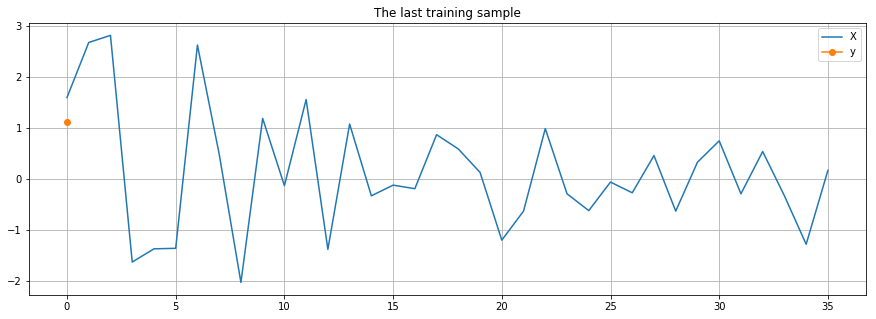

In [11]:
# One Sample
plt.figure(figsize=(15, 5))
plt.title("The last training sample")
plt.plot(X_train[0])
plt.plot(y_train[0], "-o")
plt.legend(["X", "y"])
plt.grid(True)
plt.show()

In [12]:
# Model Parameters
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_outputs = 1
num_neurons = 64
# Number of output series
learning_rate = 0.03
epochs = 1500
# Training Settings
report_periods = epochs // 10

In [13]:
parameters = {
    "num_time_steps": LAGS,
    "num_inputs": 1,
    "num_outputs": LAGS,
    "num_neurons": 64,
    "learning_rate": 0.003
}

In [14]:
model = ExtractingBaselineRnn(para=parameters, sequential_label=True)

Model: loading parameters
Building placeholders...
Building core rnn...
Building metrics and operations...


In [15]:
# Inspect Models.
model.learning_rate

0.003

In [16]:
# Getting the states
hist = {"train": [], "val": []}

saver = tf.train.Saver()

with tf.Session() as sess:
    #saver.restore(sess, "../modelFB.ckpt")
    sess.run(model.init)
    for e in range(epochs):
        progbar(e, epochs-1, 0)
        sess.run(model.train,
                 feed_dict={model.X: X_train, model.y: X_train})
        if True:
            eval_loss = lambda pred, resp: model.loss.eval(
                feed_dict={model.X: pred, model.y: resp})
            train_mse = eval_loss(X_train, X_train)
            val_mse = eval_loss(X_val, X_val)
            # based on training set
            persist_mse = ((X_train[1:] - X_train[:-1])**2).mean(axis=None)
            hist["train"].append(train_mse)
            hist["val"].append(val_mse)
            print(f"Iteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}; Persistence MSE {persist_mse:0.7f}")
    
    if model.SL:
        gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})[:,-1]
    else:
        gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)
    #save_path = saver.save(sess, "../modelFB.ckpt")
    gen_pred1 = lambda src: model.states.c.eval(feed_dict={model.X: src})
    train_states = gen_pred1(X_train)
    test_states = gen_pred1(X_test)

  [0/1499,   0.00%]Iteration [0], Training MSE 5.1472435; Validation MSE 6.1904135; Persistence MSE 15.9091740
  [1/1499,   0.07%]Iteration [1], Training MSE 5.1179223; Validation MSE 6.1561546; Persistence MSE 15.9091740
  [2/1499,   0.13%]Iteration [2], Training MSE 5.0873551; Validation MSE 6.1204915; Persistence MSE 15.9091740
  [3/1499,   0.20%]Iteration [3], Training MSE 5.0535898; Validation MSE 6.0810881; Persistence MSE 15.9091740
  [4/1499,   0.27%]Iteration [4], Training MSE 5.0141888; Validation MSE 6.0349684; Persistence MSE 15.9091740
  [5/1499,   0.33%]Iteration [5], Training MSE 5.0290442; Validation MSE 5.9837823; Persistence MSE 15.9091740
  [6/1499,   0.40%]Iteration [6], Training MSE 4.9464073; Validation MSE 5.9559669; Persistence MSE 15.9091740
  [7/1499,   0.47%]Iteration [7], Training MSE 4.9246798; Validation MSE 5.9316344; Persistence MSE 15.9091740
  [8/1499,   0.53%]Iteration [8], Training MSE 4.8992429; Validation MSE 5.9021182; Persistence MSE 15.9091740
 

  [73/1499,   4.87%]Iteration [73], Training MSE 0.1275574; Validation MSE 0.1482429; Persistence MSE 15.9091740
  [74/1499,   4.94%]Iteration [74], Training MSE 0.1237875; Validation MSE 0.1441231; Persistence MSE 15.9091740
  [75/1499,   5.00%]Iteration [75], Training MSE 0.1201896; Validation MSE 0.1402494; Persistence MSE 15.9091740
  [76/1499,   5.07%]Iteration [76], Training MSE 0.1167997; Validation MSE 0.1366324; Persistence MSE 15.9091740
  [77/1499,   5.14%]Iteration [77], Training MSE 0.1136150; Validation MSE 0.1332504; Persistence MSE 15.9091740
  [78/1499,   5.20%]Iteration [78], Training MSE 0.1106006; Validation MSE 0.1300468; Persistence MSE 15.9091740
  [79/1499,   5.27%]Iteration [79], Training MSE 0.1077156; Validation MSE 0.1269762; Persistence MSE 15.9091740
  [80/1499,   5.34%]Iteration [80], Training MSE 0.1049377; Validation MSE 0.1240178; Persistence MSE 15.9091740
  [81/1499,   5.40%]Iteration [81], Training MSE 0.1022514; Validation MSE 0.1211668; Persistenc

  [145/1499,   9.67%]Iteration [145], Training MSE 0.0200893; Validation MSE 0.0268914; Persistence MSE 15.9091740
  [146/1499,   9.74%]Iteration [146], Training MSE 0.0196684; Validation MSE 0.0264063; Persistence MSE 15.9091740
  [147/1499,   9.81%]Iteration [147], Training MSE 0.0192605; Validation MSE 0.0259372; Persistence MSE 15.9091740
  [148/1499,   9.87%]Iteration [148], Training MSE 0.0188647; Validation MSE 0.0254833; Persistence MSE 15.9091740
  [149/1499,   9.94%]Iteration [149], Training MSE 0.0184812; Validation MSE 0.0250442; Persistence MSE 15.9091740
  [150/1499,  10.01%]Iteration [150], Training MSE 0.0181092; Validation MSE 0.0246192; Persistence MSE 15.9091740
  [151/1499,  10.07%]Iteration [151], Training MSE 0.0177482; Validation MSE 0.0242076; Persistence MSE 15.9091740
  [152/1499,  10.14%]Iteration [152], Training MSE 0.0173978; Validation MSE 0.0238091; Persistence MSE 15.9091740
  [153/1499,  10.21%]Iteration [153], Training MSE 0.0170574; Validation MSE 0.0

  [217/1499,  14.48%]Iteration [217], Training MSE 0.0067506; Validation MSE 0.0104968; Persistence MSE 15.9091740
  [218/1499,  14.54%]Iteration [218], Training MSE 0.0066839; Validation MSE 0.0103968; Persistence MSE 15.9091740
  [219/1499,  14.61%]Iteration [219], Training MSE 0.0066181; Validation MSE 0.0102992; Persistence MSE 15.9091740
  [220/1499,  14.68%]Iteration [220], Training MSE 0.0065533; Validation MSE 0.0102042; Persistence MSE 15.9091740
  [221/1499,  14.74%]Iteration [221], Training MSE 0.0064895; Validation MSE 0.0101120; Persistence MSE 15.9091740
  [222/1499,  14.81%]Iteration [222], Training MSE 0.0064265; Validation MSE 0.0100229; Persistence MSE 15.9091740
  [223/1499,  14.88%]Iteration [223], Training MSE 0.0063645; Validation MSE 0.0099369; Persistence MSE 15.9091740
  [224/1499,  14.94%]Iteration [224], Training MSE 0.0063034; Validation MSE 0.0098543; Persistence MSE 15.9091740
  [225/1499,  15.01%]Iteration [225], Training MSE 0.0062430; Validation MSE 0.0

  [289/1499,  19.28%]Iteration [289], Training MSE 0.0037702; Validation MSE 0.0082129; Persistence MSE 15.9091740
  [290/1499,  19.35%]Iteration [290], Training MSE 0.0037457; Validation MSE 0.0081881; Persistence MSE 15.9091740
  [291/1499,  19.41%]Iteration [291], Training MSE 0.0037215; Validation MSE 0.0081630; Persistence MSE 15.9091740
  [292/1499,  19.48%]Iteration [292], Training MSE 0.0036975; Validation MSE 0.0081382; Persistence MSE 15.9091740
  [293/1499,  19.55%]Iteration [293], Training MSE 0.0036738; Validation MSE 0.0081141; Persistence MSE 15.9091740
  [294/1499,  19.61%]Iteration [294], Training MSE 0.0036504; Validation MSE 0.0080905; Persistence MSE 15.9091740
  [295/1499,  19.68%]Iteration [295], Training MSE 0.0036272; Validation MSE 0.0080670; Persistence MSE 15.9091740
  [296/1499,  19.75%]Iteration [296], Training MSE 0.0036043; Validation MSE 0.0080433; Persistence MSE 15.9091740
  [297/1499,  19.81%]Iteration [297], Training MSE 0.0035816; Validation MSE 0.0

  [361/1499,  24.08%]Iteration [361], Training MSE 0.0024986; Validation MSE 0.0067132; Persistence MSE 15.9091740
  [362/1499,  24.15%]Iteration [362], Training MSE 0.0024860; Validation MSE 0.0066972; Persistence MSE 15.9091740
  [363/1499,  24.22%]Iteration [363], Training MSE 0.0024734; Validation MSE 0.0066812; Persistence MSE 15.9091740
  [364/1499,  24.28%]Iteration [364], Training MSE 0.0024609; Validation MSE 0.0066652; Persistence MSE 15.9091740
  [365/1499,  24.35%]Iteration [365], Training MSE 0.0024485; Validation MSE 0.0066495; Persistence MSE 15.9091740
  [366/1499,  24.42%]Iteration [366], Training MSE 0.0024362; Validation MSE 0.0066341; Persistence MSE 15.9091740
  [367/1499,  24.48%]Iteration [367], Training MSE 0.0024240; Validation MSE 0.0066188; Persistence MSE 15.9091740
  [368/1499,  24.55%]Iteration [368], Training MSE 0.0024118; Validation MSE 0.0066033; Persistence MSE 15.9091740
  [369/1499,  24.62%]Iteration [369], Training MSE 0.0023998; Validation MSE 0.0

  [433/1499,  28.89%]Iteration [433], Training MSE 0.0017818; Validation MSE 0.0057532; Persistence MSE 15.9091740
  [434/1499,  28.95%]Iteration [434], Training MSE 0.0017740; Validation MSE 0.0057359; Persistence MSE 15.9091740
  [435/1499,  29.02%]Iteration [435], Training MSE 0.0017664; Validation MSE 0.0057171; Persistence MSE 15.9091740
  [436/1499,  29.09%]Iteration [436], Training MSE 0.0017588; Validation MSE 0.0056967; Persistence MSE 15.9091740
  [437/1499,  29.15%]Iteration [437], Training MSE 0.0017513; Validation MSE 0.0056747; Persistence MSE 15.9091740
  [438/1499,  29.22%]Iteration [438], Training MSE 0.0017439; Validation MSE 0.0056557; Persistence MSE 15.9091740
  [439/1499,  29.29%]Iteration [439], Training MSE 0.0017364; Validation MSE 0.0056438; Persistence MSE 15.9091740
  [440/1499,  29.35%]Iteration [440], Training MSE 0.0017290; Validation MSE 0.0056388; Persistence MSE 15.9091740
  [441/1499,  29.42%]Iteration [441], Training MSE 0.0017217; Validation MSE 0.0

  [505/1499,  33.69%]Iteration [505], Training MSE 0.0013393; Validation MSE 0.0051964; Persistence MSE 15.9091740
  [506/1499,  33.76%]Iteration [506], Training MSE 0.0013345; Validation MSE 0.0051909; Persistence MSE 15.9091740
  [507/1499,  33.82%]Iteration [507], Training MSE 0.0013297; Validation MSE 0.0051851; Persistence MSE 15.9091740
  [508/1499,  33.89%]Iteration [508], Training MSE 0.0013249; Validation MSE 0.0051801; Persistence MSE 15.9091740
  [509/1499,  33.96%]Iteration [509], Training MSE 0.0013201; Validation MSE 0.0051767; Persistence MSE 15.9091740
  [510/1499,  34.02%]Iteration [510], Training MSE 0.0013154; Validation MSE 0.0051689; Persistence MSE 15.9091740
  [511/1499,  34.09%]Iteration [511], Training MSE 0.0013107; Validation MSE 0.0051593; Persistence MSE 15.9091740
  [512/1499,  34.16%]Iteration [512], Training MSE 0.0013060; Validation MSE 0.0051571; Persistence MSE 15.9091740
  [513/1499,  34.22%]Iteration [513], Training MSE 0.0013013; Validation MSE 0.0

  [577/1499,  38.49%]Iteration [577], Training MSE 0.0010538; Validation MSE 0.0048443; Persistence MSE 15.9091740
  [578/1499,  38.56%]Iteration [578], Training MSE 0.0010506; Validation MSE 0.0048392; Persistence MSE 15.9091740
  [579/1499,  38.63%]Iteration [579], Training MSE 0.0010474; Validation MSE 0.0048335; Persistence MSE 15.9091740
  [580/1499,  38.69%]Iteration [580], Training MSE 0.0010442; Validation MSE 0.0048284; Persistence MSE 15.9091740
  [581/1499,  38.76%]Iteration [581], Training MSE 0.0010410; Validation MSE 0.0048238; Persistence MSE 15.9091740
  [582/1499,  38.83%]Iteration [582], Training MSE 0.0010379; Validation MSE 0.0048188; Persistence MSE 15.9091740
  [583/1499,  38.89%]Iteration [583], Training MSE 0.0010348; Validation MSE 0.0048134; Persistence MSE 15.9091740
  [584/1499,  38.96%]Iteration [584], Training MSE 0.0010316; Validation MSE 0.0048085; Persistence MSE 15.9091740
  [585/1499,  39.03%]Iteration [585], Training MSE 0.0010285; Validation MSE 0.0

  [649/1499,  43.30%]Iteration [649], Training MSE 0.0008610; Validation MSE 0.0045113; Persistence MSE 15.9091740
  [650/1499,  43.36%]Iteration [650], Training MSE 0.0008587; Validation MSE 0.0045111; Persistence MSE 15.9091740
  [651/1499,  43.43%]Iteration [651], Training MSE 0.0008565; Validation MSE 0.0045014; Persistence MSE 15.9091740
  [652/1499,  43.50%]Iteration [652], Training MSE 0.0008543; Validation MSE 0.0044988; Persistence MSE 15.9091740
  [653/1499,  43.56%]Iteration [653], Training MSE 0.0008521; Validation MSE 0.0044970; Persistence MSE 15.9091740
  [654/1499,  43.63%]Iteration [654], Training MSE 0.0008500; Validation MSE 0.0044973; Persistence MSE 15.9091740
  [655/1499,  43.70%]Iteration [655], Training MSE 0.0008478; Validation MSE 0.0044968; Persistence MSE 15.9091740
  [656/1499,  43.76%]Iteration [656], Training MSE 0.0008456; Validation MSE 0.0044838; Persistence MSE 15.9091740
  [657/1499,  43.83%]Iteration [657], Training MSE 0.0008435; Validation MSE 0.0

  [721/1499,  48.10%]Iteration [721], Training MSE 0.0007226; Validation MSE 0.0042824; Persistence MSE 15.9091740
  [722/1499,  48.17%]Iteration [722], Training MSE 0.0007210; Validation MSE 0.0042977; Persistence MSE 15.9091740
  [723/1499,  48.23%]Iteration [723], Training MSE 0.0007194; Validation MSE 0.0042709; Persistence MSE 15.9091740
  [724/1499,  48.30%]Iteration [724], Training MSE 0.0007177; Validation MSE 0.0042811; Persistence MSE 15.9091740
  [725/1499,  48.37%]Iteration [725], Training MSE 0.0007161; Validation MSE 0.0042448; Persistence MSE 15.9091740
  [726/1499,  48.43%]Iteration [726], Training MSE 0.0007144; Validation MSE 0.0042601; Persistence MSE 15.9091740
  [727/1499,  48.50%]Iteration [727], Training MSE 0.0007128; Validation MSE 0.0042679; Persistence MSE 15.9091740
  [728/1499,  48.57%]Iteration [728], Training MSE 0.0007112; Validation MSE 0.0042708; Persistence MSE 15.9091740
  [729/1499,  48.63%]Iteration [729], Training MSE 0.0007096; Validation MSE 0.0

  [793/1499,  52.90%]Iteration [793], Training MSE 0.0006204; Validation MSE 0.0041087; Persistence MSE 15.9091740
  [794/1499,  52.97%]Iteration [794], Training MSE 0.0006192; Validation MSE 0.0040174; Persistence MSE 15.9091740
  [795/1499,  53.04%]Iteration [795], Training MSE 0.0006179; Validation MSE 0.0040854; Persistence MSE 15.9091740
  [796/1499,  53.10%]Iteration [796], Training MSE 0.0006165; Validation MSE 0.0040252; Persistence MSE 15.9091740
  [797/1499,  53.17%]Iteration [797], Training MSE 0.0006152; Validation MSE 0.0040571; Persistence MSE 15.9091740
  [798/1499,  53.24%]Iteration [798], Training MSE 0.0006140; Validation MSE 0.0040509; Persistence MSE 15.9091740
  [799/1499,  53.30%]Iteration [799], Training MSE 0.0006128; Validation MSE 0.0040394; Persistence MSE 15.9091740
  [800/1499,  53.37%]Iteration [800], Training MSE 0.0006117; Validation MSE 0.0040688; Persistence MSE 15.9091740
  [801/1499,  53.44%]Iteration [801], Training MSE 0.0006105; Validation MSE 0.0

  [865/1499,  57.71%]Iteration [865], Training MSE 0.0005415; Validation MSE 0.0038228; Persistence MSE 15.9091740
  [866/1499,  57.77%]Iteration [866], Training MSE 0.0005405; Validation MSE 0.0038038; Persistence MSE 15.9091740
  [867/1499,  57.84%]Iteration [867], Training MSE 0.0005396; Validation MSE 0.0038120; Persistence MSE 15.9091740
  [868/1499,  57.91%]Iteration [868], Training MSE 0.0005386; Validation MSE 0.0037973; Persistence MSE 15.9091740
  [869/1499,  57.97%]Iteration [869], Training MSE 0.0005377; Validation MSE 0.0038043; Persistence MSE 15.9091740
  [870/1499,  58.04%]Iteration [870], Training MSE 0.0005367; Validation MSE 0.0037868; Persistence MSE 15.9091740
  [871/1499,  58.11%]Iteration [871], Training MSE 0.0005358; Validation MSE 0.0037928; Persistence MSE 15.9091740
  [872/1499,  58.17%]Iteration [872], Training MSE 0.0005348; Validation MSE 0.0037795; Persistence MSE 15.9091740
  [873/1499,  58.24%]Iteration [873], Training MSE 0.0005339; Validation MSE 0.0

  [937/1499,  62.51%]Iteration [937], Training MSE 0.0004807; Validation MSE 0.0034986; Persistence MSE 15.9091740
  [938/1499,  62.58%]Iteration [938], Training MSE 0.0004810; Validation MSE 0.0037077; Persistence MSE 15.9091740
  [939/1499,  62.64%]Iteration [939], Training MSE 0.0004809; Validation MSE 0.0034389; Persistence MSE 15.9091740
  [940/1499,  62.71%]Iteration [940], Training MSE 0.0004806; Validation MSE 0.0037580; Persistence MSE 15.9091740
  [941/1499,  62.78%]Iteration [941], Training MSE 0.0004800; Validation MSE 0.0034071; Persistence MSE 15.9091740
  [942/1499,  62.84%]Iteration [942], Training MSE 0.0004777; Validation MSE 0.0037420; Persistence MSE 15.9091740
  [943/1499,  62.91%]Iteration [943], Training MSE 0.0004753; Validation MSE 0.0034842; Persistence MSE 15.9091740
  [944/1499,  62.98%]Iteration [944], Training MSE 0.0004733; Validation MSE 0.0036196; Persistence MSE 15.9091740
  [945/1499,  63.04%]Iteration [945], Training MSE 0.0004727; Validation MSE 0.0

  [1008/1499,  67.24%]Iteration [1008], Training MSE 0.0004284; Validation MSE 0.0034053; Persistence MSE 15.9091740
  [1009/1499,  67.31%]Iteration [1009], Training MSE 0.0004277; Validation MSE 0.0034064; Persistence MSE 15.9091740
  [1010/1499,  67.38%]Iteration [1010], Training MSE 0.0004271; Validation MSE 0.0034003; Persistence MSE 15.9091740
  [1011/1499,  67.44%]Iteration [1011], Training MSE 0.0004265; Validation MSE 0.0034017; Persistence MSE 15.9091740
  [1012/1499,  67.51%]Iteration [1012], Training MSE 0.0004258; Validation MSE 0.0033965; Persistence MSE 15.9091740
  [1013/1499,  67.58%]Iteration [1013], Training MSE 0.0004252; Validation MSE 0.0033988; Persistence MSE 15.9091740
  [1014/1499,  67.65%]Iteration [1014], Training MSE 0.0004246; Validation MSE 0.0033915; Persistence MSE 15.9091740
  [1015/1499,  67.71%]Iteration [1015], Training MSE 0.0004239; Validation MSE 0.0033954; Persistence MSE 15.9091740
  [1016/1499,  67.78%]Iteration [1016], Training MSE 0.0004233; 

  [1078/1499,  71.91%]Iteration [1078], Training MSE 0.0003872; Validation MSE 0.0032925; Persistence MSE 15.9091740
  [1079/1499,  71.98%]Iteration [1079], Training MSE 0.0003866; Validation MSE 0.0032542; Persistence MSE 15.9091740
  [1080/1499,  72.05%]Iteration [1080], Training MSE 0.0003861; Validation MSE 0.0032956; Persistence MSE 15.9091740
  [1081/1499,  72.11%]Iteration [1081], Training MSE 0.0003855; Validation MSE 0.0032462; Persistence MSE 15.9091740
  [1082/1499,  72.18%]Iteration [1082], Training MSE 0.0003850; Validation MSE 0.0032887; Persistence MSE 15.9091740
  [1083/1499,  72.25%]Iteration [1083], Training MSE 0.0003845; Validation MSE 0.0032427; Persistence MSE 15.9091740
  [1084/1499,  72.31%]Iteration [1084], Training MSE 0.0003839; Validation MSE 0.0032813; Persistence MSE 15.9091740
  [1085/1499,  72.38%]Iteration [1085], Training MSE 0.0003834; Validation MSE 0.0032426; Persistence MSE 15.9091740
  [1086/1499,  72.45%]Iteration [1086], Training MSE 0.0003829; 

  [1148/1499,  76.58%]Iteration [1148], Training MSE 0.0003524; Validation MSE 0.0031382; Persistence MSE 15.9091740
  [1149/1499,  76.65%]Iteration [1149], Training MSE 0.0003521; Validation MSE 0.0032337; Persistence MSE 15.9091740
  [1150/1499,  76.72%]Iteration [1150], Training MSE 0.0003519; Validation MSE 0.0031244; Persistence MSE 15.9091740
  [1151/1499,  76.78%]Iteration [1151], Training MSE 0.0003517; Validation MSE 0.0032529; Persistence MSE 15.9091740
  [1152/1499,  76.85%]Iteration [1152], Training MSE 0.0003517; Validation MSE 0.0031020; Persistence MSE 15.9091740
  [1153/1499,  76.92%]Iteration [1153], Training MSE 0.0003515; Validation MSE 0.0032802; Persistence MSE 15.9091740
  [1154/1499,  76.98%]Iteration [1154], Training MSE 0.0003516; Validation MSE 0.0030830; Persistence MSE 15.9091740
  [1155/1499,  77.05%]Iteration [1155], Training MSE 0.0003513; Validation MSE 0.0033055; Persistence MSE 15.9091740
  [1156/1499,  77.12%]Iteration [1156], Training MSE 0.0003511; 

  [1218/1499,  81.25%]Iteration [1218], Training MSE 0.0003230; Validation MSE 0.0032297; Persistence MSE 15.9091740
  [1219/1499,  81.32%]Iteration [1219], Training MSE 0.0003223; Validation MSE 0.0030794; Persistence MSE 15.9091740
  [1220/1499,  81.39%]Iteration [1220], Training MSE 0.0003215; Validation MSE 0.0031999; Persistence MSE 15.9091740
  [1221/1499,  81.45%]Iteration [1221], Training MSE 0.0003207; Validation MSE 0.0030869; Persistence MSE 15.9091740
  [1222/1499,  81.52%]Iteration [1222], Training MSE 0.0003200; Validation MSE 0.0031616; Persistence MSE 15.9091740
  [1223/1499,  81.59%]Iteration [1223], Training MSE 0.0003194; Validation MSE 0.0031170; Persistence MSE 15.9091740
  [1224/1499,  81.65%]Iteration [1224], Training MSE 0.0003189; Validation MSE 0.0031380; Persistence MSE 15.9091740
  [1225/1499,  81.72%]Iteration [1225], Training MSE 0.0003185; Validation MSE 0.0031424; Persistence MSE 15.9091740
  [1226/1499,  81.79%]Iteration [1226], Training MSE 0.0003182; 

  [1288/1499,  85.92%]Iteration [1288], Training MSE 0.0003076; Validation MSE 0.0034037; Persistence MSE 15.9091740
  [1289/1499,  85.99%]Iteration [1289], Training MSE 0.0002987; Validation MSE 0.0030645; Persistence MSE 15.9091740
  [1290/1499,  86.06%]Iteration [1290], Training MSE 0.0002942; Validation MSE 0.0031660; Persistence MSE 15.9091740
  [1291/1499,  86.12%]Iteration [1291], Training MSE 0.0002961; Validation MSE 0.0032090; Persistence MSE 15.9091740
  [1292/1499,  86.19%]Iteration [1292], Training MSE 0.0003013; Validation MSE 0.0029672; Persistence MSE 15.9091740
  [1293/1499,  86.26%]Iteration [1293], Training MSE 0.0003042; Validation MSE 0.0033168; Persistence MSE 15.9091740
  [1294/1499,  86.32%]Iteration [1294], Training MSE 0.0003036; Validation MSE 0.0029815; Persistence MSE 15.9091740
  [1295/1499,  86.39%]Iteration [1295], Training MSE 0.0002977; Validation MSE 0.0033013; Persistence MSE 15.9091740
  [1296/1499,  86.46%]Iteration [1296], Training MSE 0.0002930; 

  [1358/1499,  90.59%]Iteration [1358], Training MSE 0.0002767; Validation MSE 0.0029729; Persistence MSE 15.9091740
  [1359/1499,  90.66%]Iteration [1359], Training MSE 0.0002771; Validation MSE 0.0032066; Persistence MSE 15.9091740
  [1360/1499,  90.73%]Iteration [1360], Training MSE 0.0002768; Validation MSE 0.0029866; Persistence MSE 15.9091740
  [1361/1499,  90.79%]Iteration [1361], Training MSE 0.0002747; Validation MSE 0.0032015; Persistence MSE 15.9091740
  [1362/1499,  90.86%]Iteration [1362], Training MSE 0.0002725; Validation MSE 0.0030265; Persistence MSE 15.9091740
  [1363/1499,  90.93%]Iteration [1363], Training MSE 0.0002706; Validation MSE 0.0031244; Persistence MSE 15.9091740
  [1364/1499,  90.99%]Iteration [1364], Training MSE 0.0002695; Validation MSE 0.0030503; Persistence MSE 15.9091740
  [1365/1499,  91.06%]Iteration [1365], Training MSE 0.0002693; Validation MSE 0.0030202; Persistence MSE 15.9091740
  [1366/1499,  91.13%]Iteration [1366], Training MSE 0.0002697; 

  [1428/1499,  95.26%]Iteration [1428], Training MSE 0.0002517; Validation MSE 0.0030463; Persistence MSE 15.9091740
  [1429/1499,  95.33%]Iteration [1429], Training MSE 0.0002518; Validation MSE 0.0029549; Persistence MSE 15.9091740
  [1430/1499,  95.40%]Iteration [1430], Training MSE 0.0002520; Validation MSE 0.0030546; Persistence MSE 15.9091740
  [1431/1499,  95.46%]Iteration [1431], Training MSE 0.0002524; Validation MSE 0.0029364; Persistence MSE 15.9091740
  [1432/1499,  95.53%]Iteration [1432], Training MSE 0.0002529; Validation MSE 0.0030802; Persistence MSE 15.9091740
  [1433/1499,  95.60%]Iteration [1433], Training MSE 0.0002539; Validation MSE 0.0029272; Persistence MSE 15.9091740
  [1434/1499,  95.66%]Iteration [1434], Training MSE 0.0002550; Validation MSE 0.0031221; Persistence MSE 15.9091740
  [1435/1499,  95.73%]Iteration [1435], Training MSE 0.0002571; Validation MSE 0.0029151; Persistence MSE 15.9091740
  [1436/1499,  95.80%]Iteration [1436], Training MSE 0.0002589; 

  [1498/1499,  99.93%]Iteration [1498], Training MSE 0.0002613; Validation MSE 0.0032817; Persistence MSE 15.9091740
  [1499/1499, 100.00%]Iteration [1499], Training MSE 0.0002662; Validation MSE 0.0028111; Persistence MSE 15.9091740


In [17]:
# Number of correct signs
# start with initial credibility
cred = 1000
for i in range(len(y_test)):
    if y_test[i][0] * p_test[i][0] >= 0:
        # predicted the same sign
        cred += 1
    else:
        cred -= 1
print(cred)

861


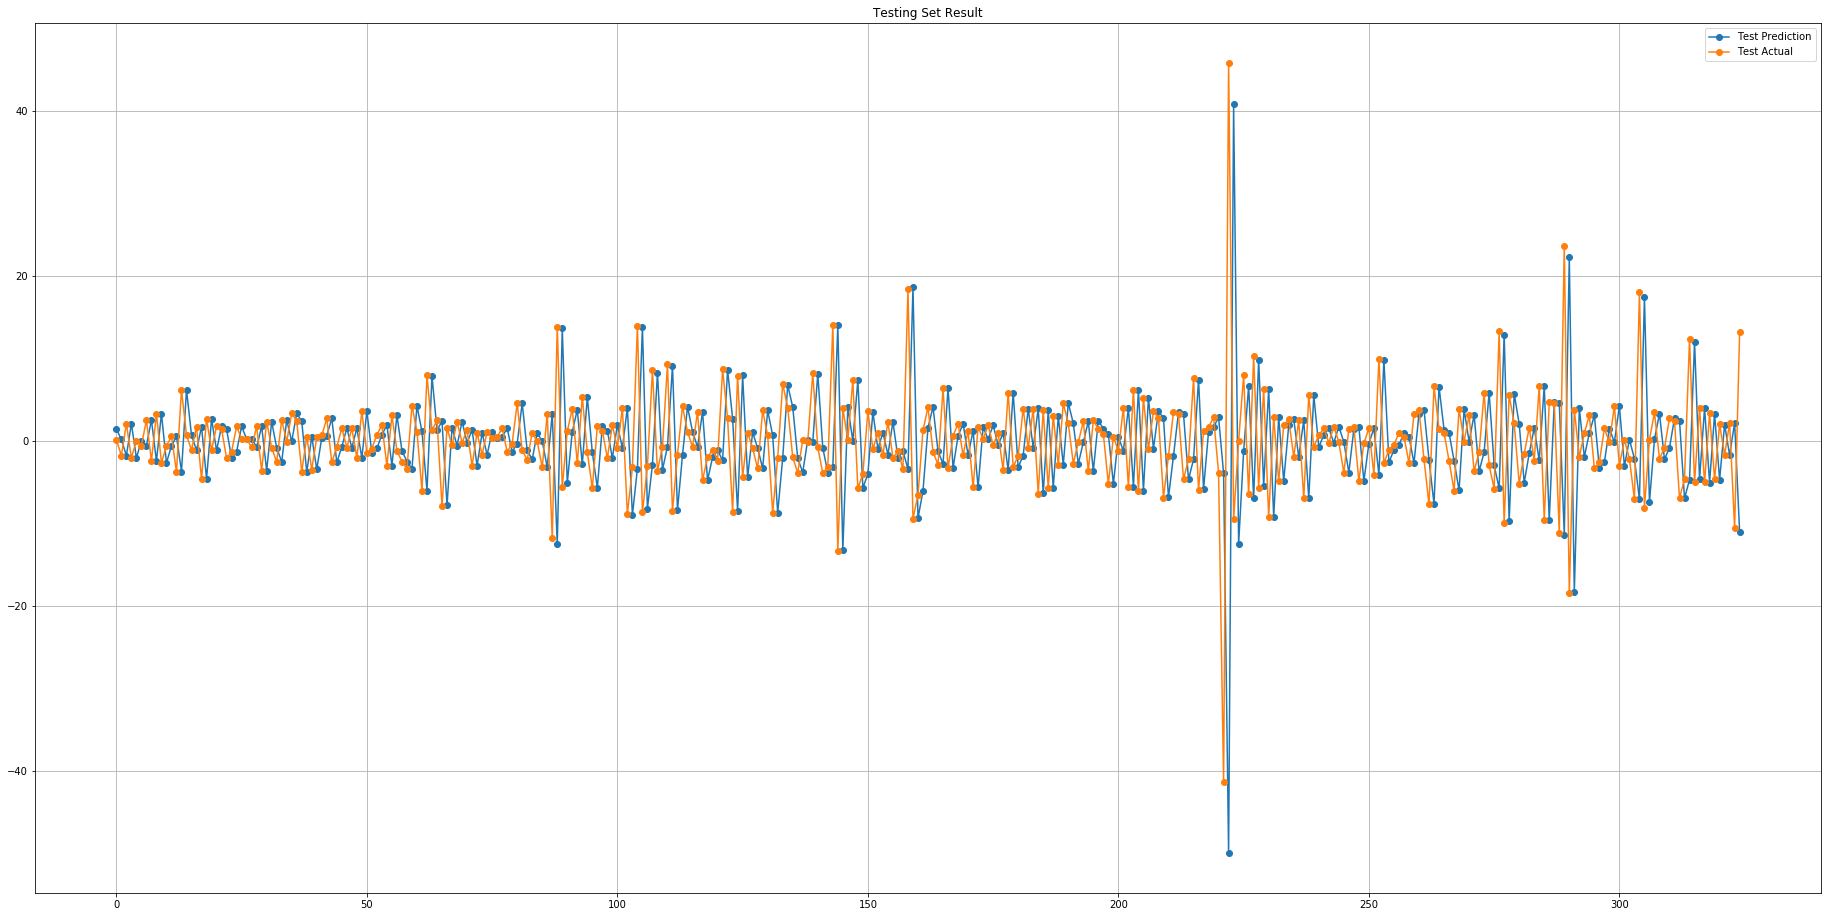

In [18]:
# Visualize testing set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Testing Set Result")
if model.SL:
    plt.errorbar(list(range(len(p_test[:, -1]))), p_test[:, -1], marker='o')
    plt.errorbar(list(range(len(y_test[:, -1]))), y_test[:,-1], marker='o')
#     plt.plot(np.squeeze(p_test[:,-1]))
#     plt.plot(np.squeeze(y_test[:,-1]))
else:
    plt.plot(np.squeeze(p_test))
    plt.plot(np.squeeze(y_test))
plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

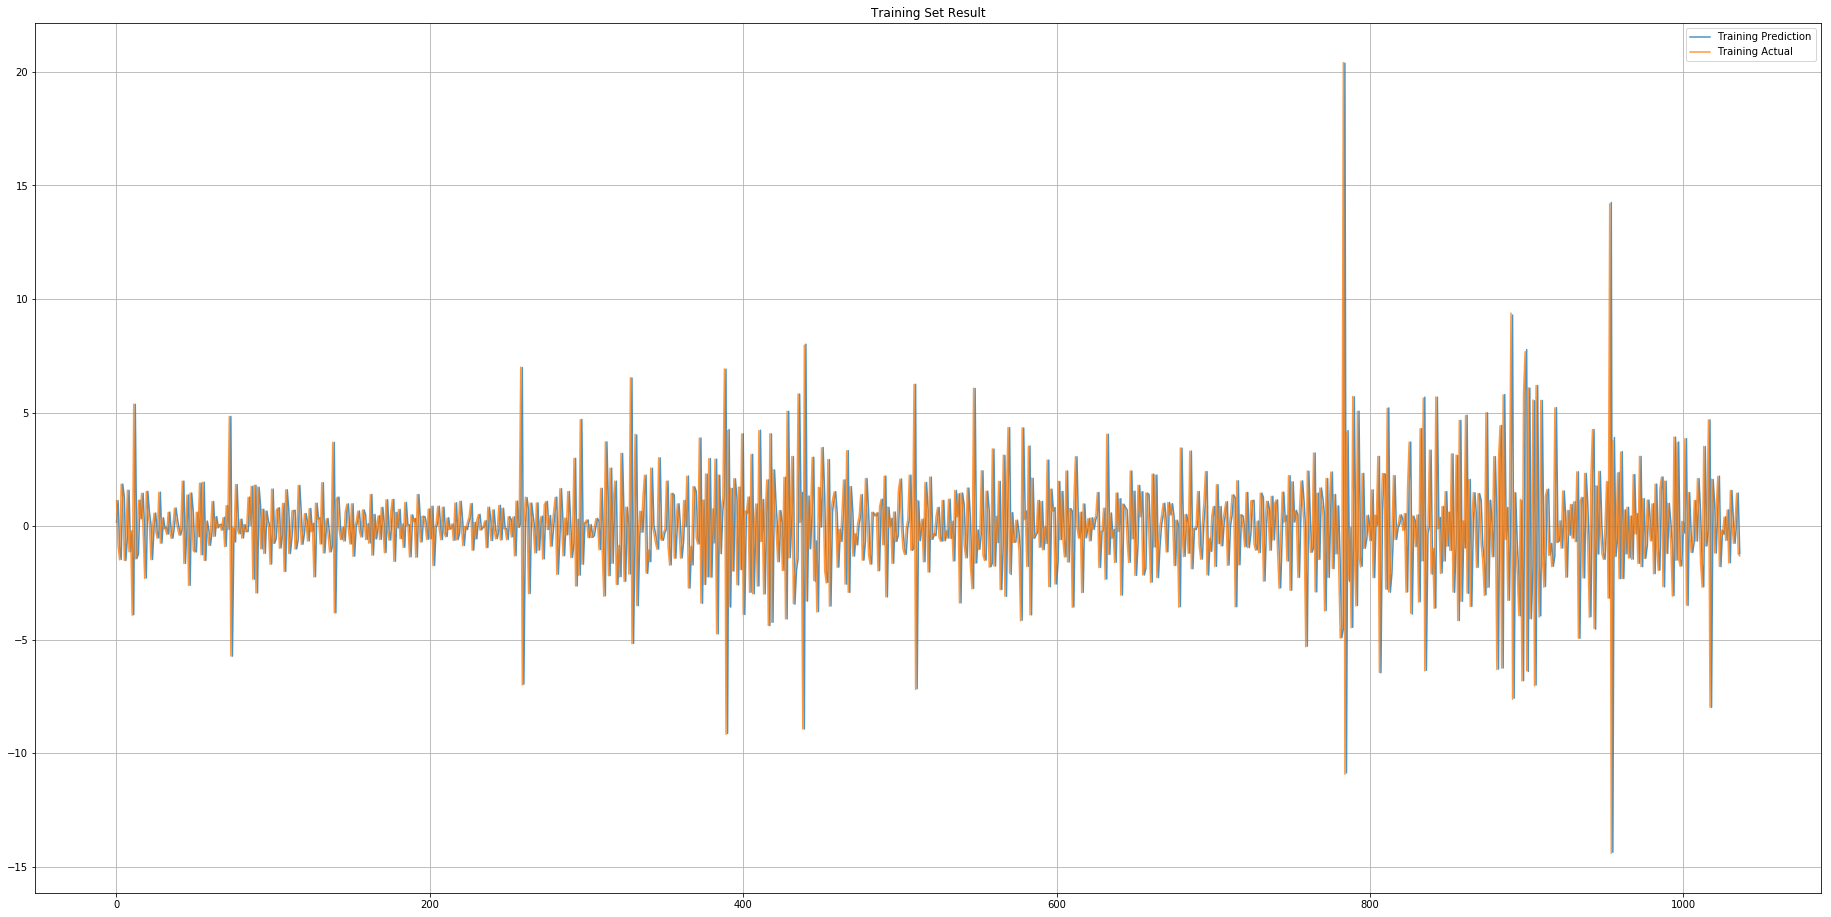

In [19]:
# Visualize training set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Training Set Result")
if model.SL:
    plt.plot(np.squeeze(p_train[:,-1]), alpha=0.8)
    plt.plot(np.squeeze(y_train[:,-1]), alpha=0.8)
else:
    plt.plot(np.squeeze(p_train), alpha=0.8)
    plt.plot(np.squeeze(y_train), alpha=0.8)
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

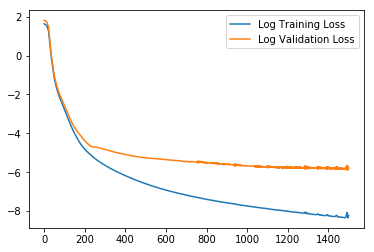

In [20]:
plt.close()
plt.plot(np.log(hist["train"]))
plt.plot(np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()

In [ ]:
parameters = {
    "num_time_steps": 64,
    "num_inputs": 1,
    "num_outputs": 1,
    "num_neurons": 128,
    "learning_rate": 0.003
}
model = ExtractingBaselineRnn(para=parameters, sequential_label=True)

train_states = train_states.reshape(-1, 64, 1)
test_states = test_states.reshape(-1, 64, 1)
y_train = y_train.reshape(-1, 1, 1)
y_test = y_test.reshape(-1, 1, 1)
print(train_states.shape, test_states.shape)

Model: loading parameters
Building placeholders...
Building core rnn...
Building metrics and operations...
(1037, 64, 1) (325, 64, 1)


In [ ]:
epochs = 100
model = ExtractingBaselineRnn(para=parameters, sequential_label=True)
hist["train"] = []
# corresponding states should be trained and recorded for the training set, don't have to make one for testing
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(model.init)
    for e in range(epochs):
        progbar(e, epochs-1, 0)
        sess.run(model.train,
                 feed_dict={model.X: train_states, model.y: y_train})
        if True:
            eval_loss = lambda pred, resp: model.loss.eval(
                feed_dict={model.X: pred, model.y: resp})
            train_mse = eval_loss(train_states, y_train)
            # based on training set
            persist_mse = ((y_train[1:] - y_train[:-1])**2).mean(axis=None)
            hist["train"].append(train_mse)
            print(f"Iteration [{e}], Training MSE {train_mse:0.7f}; Persistence MSE {persist_mse:0.7f}")
    
    gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})[:,-1]
    p_train = gen_pred(train_states)
    p_test = gen_pred(test_states)
    save_path = saver.save(sess, "../modelFB_pred.ckpt")

Model: loading parameters
Building placeholders...
Building core rnn...
Building metrics and operations...
  [0/99,   0.00%]Iteration [0], Training MSE 5.2125621; Persistence MSE 16.0886440
  [1/99,   1.01%]Iteration [1], Training MSE 5.2064538; Persistence MSE 16.0886440
  [2/99,   2.02%]Iteration [2], Training MSE 5.2045088; Persistence MSE 16.0886440
  [3/99,   3.03%]Iteration [3], Training MSE 5.1977372; Persistence MSE 16.0886440
  [4/99,   4.04%]Iteration [4], Training MSE 5.1872816; Persistence MSE 16.0886440
  [5/99,   5.05%]Iteration [5], Training MSE 59002.6328125; Persistence MSE 16.0886440
  [6/99,   6.06%]Iteration [6], Training MSE 253961968.0000000; Persistence MSE 16.0886440
  [7/99,   7.07%]

In [ ]:
# Visualize testing set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Testing Set Result")
#plt.plot(np.squeeze(p_test))
#plt.plot(np.squeeze(y_test[:,-1]))
plt.errorbar(list(range(len(p_test))), p_test, marker='o')
plt.errorbar(list(range(len(y_test[:, -1]))), y_test[:,-1], marker='o')
plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

In [ ]:
# Number of correct signs
# start with initial credibility
cred = 1000
for i in range(len(y_test)):
    if y_test[i][0] * p_test[i][0] >= 0:
        # predicted the same sign
        cred += 1
    else:
        cred -= 1
print(cred)